# **Using data from PubMed RCT to check if each line is either  'BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE' or 'RESULTS'**

Dataset link: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
from helper_functions import *
import tensorflow as tf
import tensorflow.keras.layers as layers

--2021-11-09 04:21:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-09 04:21:01 (76.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [3]:
import os
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

***Experimenting with 20,000 dataset***

Using sentences as inputs

**Pre Processing Texts to be passed through the model**

In [4]:
def get_lines(filename):
    with open(filename, "r") as f:
      return f.readlines()
train_lines = get_lines(data_dir+"train.txt")

In [5]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [7]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 444 ms, sys: 121 ms, total: 565 ms
Wall time: 571 ms


In [8]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


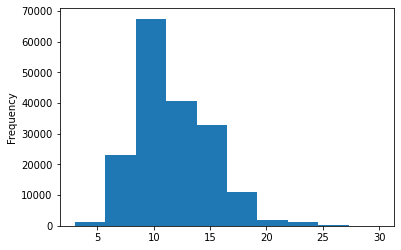

In [9]:
train_df.total_lines.plot.hist();

In [10]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [11]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))


In [12]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


In [13]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

**Forming texts into tensors**

In [14]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_tokens = 68000
text_vectorizer1 = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55)
text_vectorizer1.adapt(train_sentences)

In [15]:
vocab = text_vectorizer1.get_vocabulary()

In [16]:
token_embed = layers.Embedding(
    input_dim = len(vocab),
    output_dim = 128,
    mask_zero = True
)

**Forming datasets and using multi threading**

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [18]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))

In [19]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
len(train_labels_one_hot)

180040

**Experimenting with 1 Dimensional Convutional Neural Networks**

In [21]:
inp = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer1(inp)
x = token_embed(x)
x = layers.Conv1D(64,5,1,activation="relu",padding="same")(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(64,5,1,activation="relu",padding="same")(x)
x = layers.MaxPool1D()(x)
x = layers.GlobalAveragePooling1D()(x)
outz = layers.Dense(int(len(label_encoder.classes_)),activation="sigmoid")(x)

model_11= tf.keras.Model(inp,outz)
model_11.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embedding (Embedding)        (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 64)            0     

In [22]:
model_11.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [23]:
track_1_f = model_11.fit(train_dataset,
                         steps_per_epoch = int(0.1*len(train_dataset)),
                         epochs = 3,
                         validation_data = val_dataset,
                         validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 16ms/step - loss: 0.8644 - accuracy: 0.6542 - val_loss: 0.6757 - val_accuracy: 0.7487
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6454 - accuracy: 0.7620 - val_loss: 0.6265 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.5961 - accuracy: 0.7817 - val_loss: 0.5634 - val_accuracy: 0.8009


Plotting Loss Curves

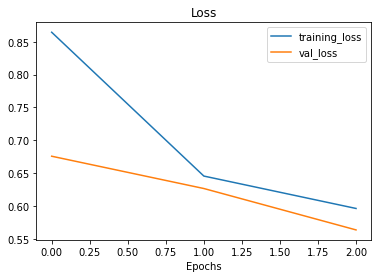

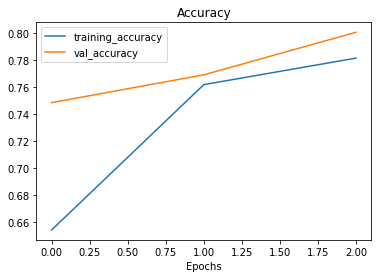

In [24]:
plot_loss_curves(track_1_f)

In [25]:
model_11_preds_probs = model_11.predict(val_dataset)

In [26]:
model_11_preds = tf.argmax(model_11_preds_probs,axis = 1)

Model Result Analysis

In [27]:
z = (calculate_results(val_labels_encoded,model_11_preds))
z

{'accuracy': 79.46842314312194,
 'f1': 0.7941287078467599,
 'precision': 0.7947058943294604,
 'recall': 0.7946842314312194}

**Experimenting with Universal Sentence Encoder**

In [28]:
import tensorflow_hub as hub
sEnc = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                      input_shape=[],
                      dtype = tf.string)

In [29]:
model_12 = tf.keras.Sequential([
                               sEnc,
                                layers.Dense(64,activation="relu"),
                                layers.Dense(128,activation="relu"),
                               layers.Dense(64,activation="relu"),
                               layers.Dense(int(len(label_encoder.classes_)),activation="sigmoid")
])
model_12.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_12.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 256,847,557
Trainable params: 49,733
Non-trainable params: 256,797,824
_________________________________________________________________


In [30]:
model_12.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [31]:
track_2_f = model_12.fit(train_dataset,
                         steps_per_epoch = int(0.1*len(train_dataset)),
                         epochs = 3,
                         validation_data = val_dataset,
                         validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.8967 - accuracy: 0.6445 - val_loss: 0.7792 - val_accuracy: 0.6965
Epoch 2/3
562/562 [==============================] - 12s 22ms/step - loss: 0.7452 - accuracy: 0.7105 - val_loss: 0.7173 - val_accuracy: 0.7214
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7172 - accuracy: 0.7232 - val_loss: 0.6883 - val_accuracy: 0.7334


Plotting loss curves

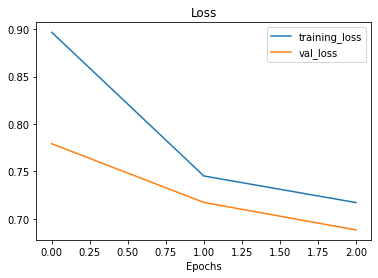

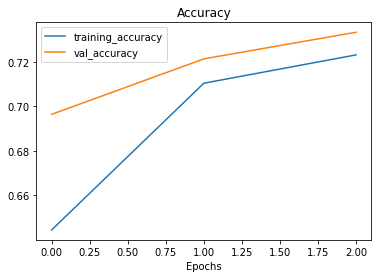

In [32]:
plot_loss_curves(track_2_f)

Model Result Analysis

In [33]:
model_11_preds_probs = model_12.predict(val_dataset)
model_11_preds = tf.argmax(model_11_preds_probs,axis = 1)
z = (calculate_results(val_labels_encoded,model_11_preds))
z

{'accuracy': 73.16298159671653,
 'f1': 0.7310988763107475,
 'precision': 0.7323979366486263,
 'recall': 0.7316298159671654}

***Using Character Level encoding i.e each character also used as input***

In [34]:
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [35]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

**Building a character tokenizer model**

In [36]:
# Create char-level token vectorizer instance
output_seq_char_len = 290
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [37]:
char_vocab = char_vectorizer.get_vocabulary()

In [38]:
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [39]:
import tensorflow.keras.layers as layers
import tensorflow_hub as hub

In [40]:
char_embed = layers.Embedding(
    input_dim = NUM_CHAR_TOKENS,
    output_dim = 25,
    mask_zero = True
)

In [41]:
inp = layers.Input(shape=(1,),dtype=tf.string)
x = char_vectorizer(inp)
x = char_embed(x)
x = layers.Conv1D(64,5,1,activation="relu",padding="same")(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(64,5,1,activation="relu",padding="same")(x)
x = layers.MaxPool1D()(x)
x = layers.GlobalAvgPool1D()(x)
outz = layers.Dense(int(len(label_encoder.classes_)),activation="sigmoid")(x)

model_13= tf.keras.Model(inp,outz)
model_13.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 290, 25)           1750      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 145, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 145, 64)           20544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 72, 64)            0   

In [42]:
model_13.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

**Forming tensor batch datasets by prefetching and using multi threading** 

In [43]:
train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_char = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [44]:
track_3_f = model_13.fit(train_dataset_char,
                         steps_per_epoch = int(0.1*len(train_dataset_char)),
                         epochs = 3,
                         validation_data = val_dataset_char,
                         validation_steps = int(0.1*len(val_dataset_char)))

Epoch 1/3
562/562 [==============================] - 8s 12ms/step - loss: 1.3910 - accuracy: 0.3770 - val_loss: 1.2474 - val_accuracy: 0.4771
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 1.2238 - accuracy: 0.4814 - val_loss: 1.1781 - val_accuracy: 0.5126
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 1.1633 - accuracy: 0.5227 - val_loss: 1.1090 - val_accuracy: 0.5359


Plotting Loss Curves

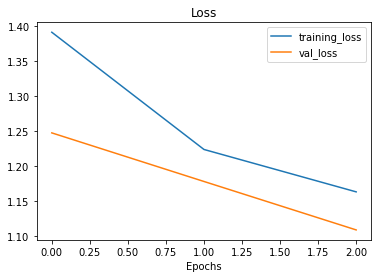

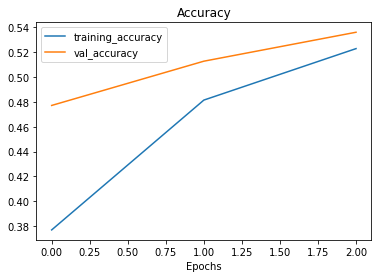

In [45]:
plot_loss_curves(track_3_f)

**Experimenting a model with both pretrained character embeddings and sentence(token) embeddings**

In [46]:
import tensorflow_hub as hub
import tensorflow.keras.layers as layers

In [47]:
uni_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                      trainable = False)

In [48]:
token_inputs = layers.Input(shape = [], dtype = tf.string)
token_embeddings = uni_embed(token_inputs)
token_out = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_out)
char_inputs = layers.Input(shape = [], dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.GRU(128))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                             outputs = char_bi_lstm)
token_char_con = layers.Concatenate()([token_model.output,char_model.output])
combined_drop = layers.Dropout(0.5)(token_char_con)

#layer_1 = layers.Bidirectional(layers.GRU(64))(combined_drop)
#layer_2 = layers.Bidirectional(layers.GRU(64))(layer_1)
#layer_3 = layers.GlobalAveragePooling1D()(layer_2)
semi_out = layers.Dense(128,activation = "relu")(combined_drop)
final_dropout = layers.Dropout(0.5)(semi_out)
output_layer = layers.Dense(int(len(label_encoder.classes_)),activation="sigmoid")(final_dropout)

hybrid_model = tf.keras.Model(inputs = [token_model.input,char_model.input] ,
                              outputs = output_layer) 

In [49]:
hybrid_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           input_4[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          256797824   input_3[0][0]                    
____________________________________________________________________________________________

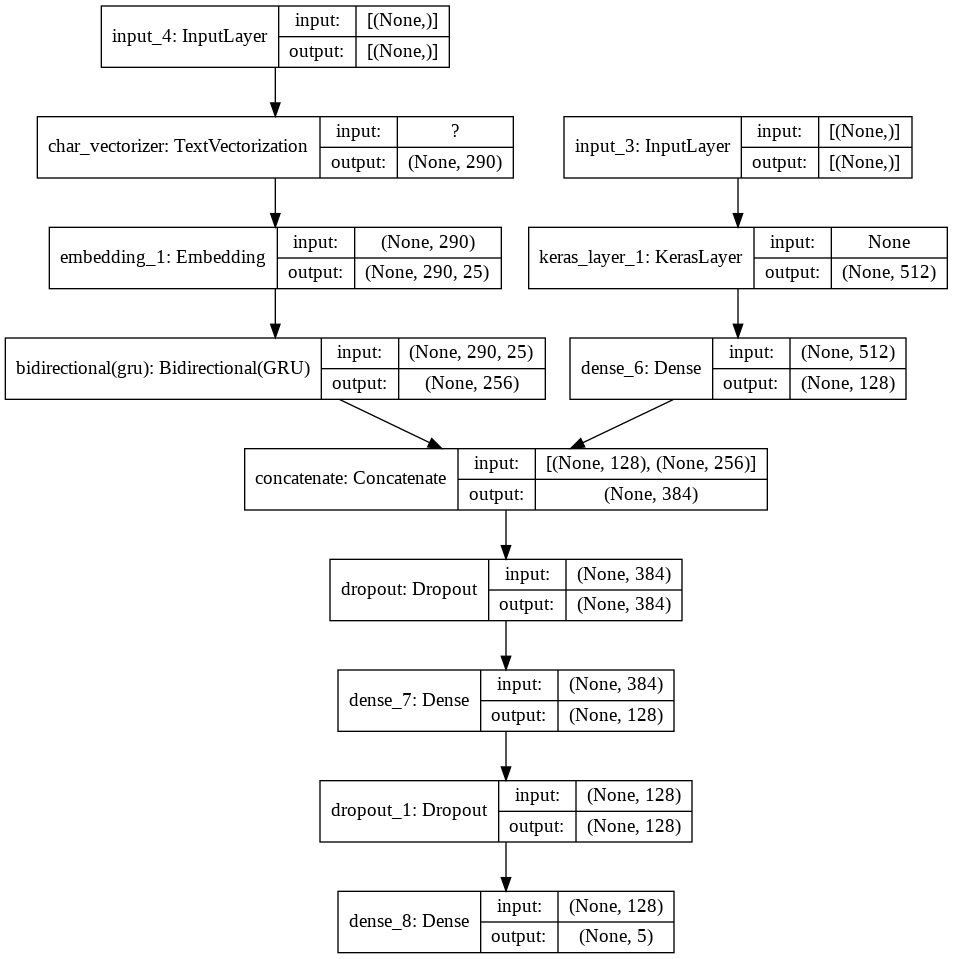

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(hybrid_model,show_shapes = True)

In [51]:
hybrid_model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

**Forming tensor batch datasets by prefetching and using multi threading** 

In [52]:
combined_train_dats = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)),tf.data.Dataset.from_tensor_slices(train_labels_one_hot))).batch(32).prefetch(tf.data.AUTOTUNE)
combined_test_dats = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((test_sentences,test_chars)),tf.data.Dataset.from_tensor_slices(test_labels_one_hot))).batch(32).prefetch(tf.data.AUTOTUNE)
combined_val_dats = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)),tf.data.Dataset.from_tensor_slices(val_labels_one_hot))).batch(32).prefetch(tf.data.AUTOTUNE)

In [53]:
hybrid_track = hybrid_model.fit(combined_train_dats,
                         steps_per_epoch = int(0.1*len(combined_train_dats)),
                         epochs = 3,
                         validation_data = combined_val_dats,
                         validation_steps = int(0.1*len(combined_val_dats)))

Epoch 1/3
562/562 [==============================] - 103s 164ms/step - loss: 0.9693 - accuracy: 0.6136 - val_loss: 0.7775 - val_accuracy: 0.7018
Epoch 2/3
562/562 [==============================] - 89s 158ms/step - loss: 0.7937 - accuracy: 0.6925 - val_loss: 0.7201 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 85s 151ms/step - loss: 0.7682 - accuracy: 0.7053 - val_loss: 0.6907 - val_accuracy: 0.7467


Plotting Loss Curves

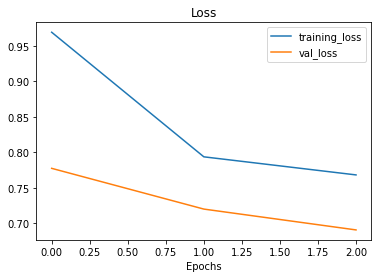

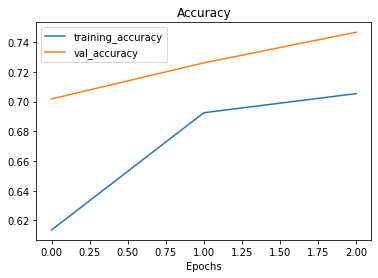

In [54]:
plot_loss_curves(hybrid_track)

Model Results Analysis

In [55]:
hybrid_model_probs = hybrid_model.predict(combined_val_dats)
hybrid_preds = tf.argmax(hybrid_model_probs, axis = 1 )
model_results = calculate_results(val_labels_encoded,hybrid_preds)
model_results

{'accuracy': 73.49066596054547,
 'f1': 0.7337034738632059,
 'precision': 0.7359132157773624,
 'recall': 0.7349066596054548}

*Integrating Line Numbers into the model*

In [56]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [57]:
np.percentile(train_df.total_lines, 98)

20.0

In [58]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

**Using pre trained Universal Sentence Encoder alongside Character encodings and position of the respective lines**

In [59]:
token_inputs = layers.Input(shape = [],dtype = tf.string, name = "token_layer")
token_embeddings = uni_embed(token_inputs)
token_outs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outs)

char_inputs = layers.Input(shape =(1,),dtype=tf.string)
char_vector = char_vectorizer(char_inputs)
char_embedi = char_embed(char_vector)
char_bi = layers.Bidirectional(layers.GRU(24))(char_embedi)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi)


line_in = layers.Input((15,),dtype = tf.float32)
x = layers.Dense(32,activation="relu")(line_in)
line_number_model = tf.keras.Model(inputs=line_in,
                                   outputs=x)

total_lines_in = layers.Input((20,),dtype = tf.float32)
y = layers.Dense(32,activation="relu")(total_lines_in)
total_line_number_model = tf.keras.Model(inputs=total_lines_in,
                                   outputs=y)

combined_embeddings = layers.Concatenate()([token_model.output,char_model.output])

zz = layers.Dense(64,activation = "relu")(combined_embeddings)
zz = layers.Dropout(0.5)(zz)

pos_emb = layers.Concatenate()([line_number_model.output,total_line_number_model.output,zz])
output_layer = layers.Dense(int(len(label_encoder.classes_)),activation="sigmoid")(pos_emb)

tri_model = tf.keras.Model(inputs = [line_number_model.input,
                                     total_line_number_model.input,
                                     token_model.input,
                                     char_model.input],
                           outputs = output_layer)

In [60]:
tri_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_layer (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           input_5[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          256797824   token_layer[0][0]                
____________________________________________________________________________________________

Visualizing the model

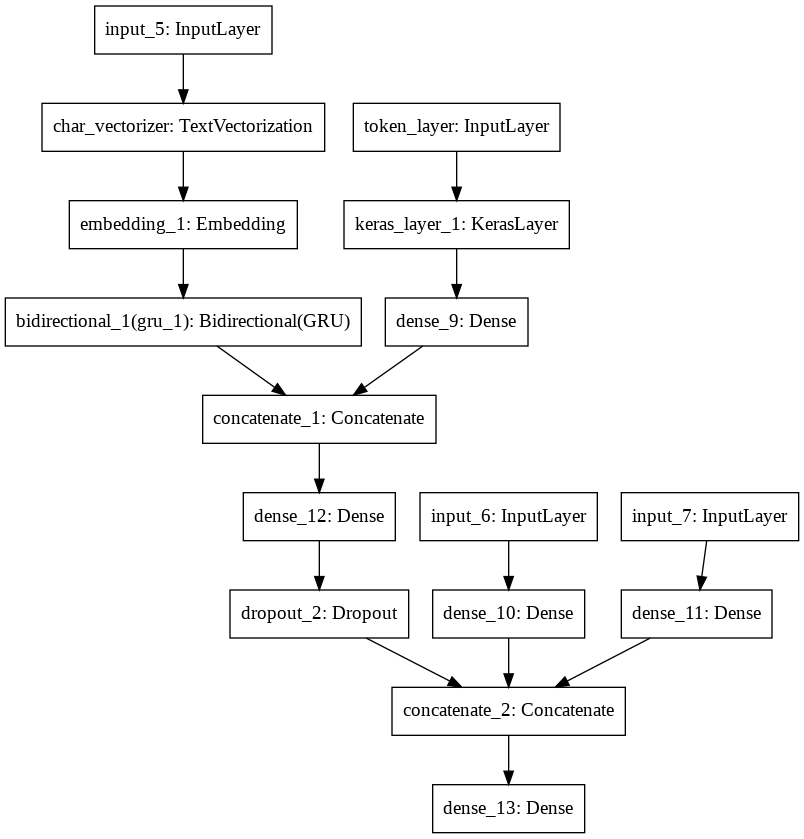

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(tri_model)

In [62]:
tri_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ["accuracy"])

**Forming tensor batch datasets by prefetching and using multi threading** 

In [63]:
train_everything_data= tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars)),tf.data.Dataset.from_tensor_slices(train_labels_one_hot))).batch(32).prefetch(tf.data.AUTOTUNE)
test_everything_data= tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_total_lines_one_hot,test_sentences,test_chars)),tf.data.Dataset.from_tensor_slices(test_labels_one_hot))).batch(32).prefetch(tf.data.AUTOTUNE)
val_everything_data= tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars)),tf.data.Dataset.from_tensor_slices(val_labels_one_hot))).batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
tribed_track = tri_model.fit(train_everything_data,
                         steps_per_epoch = int(0.1*len(train_everything_data)),
                         epochs = 3,
                         validation_data = val_everything_data,
                         validation_steps = int(0.1*len(val_everything_data)))

Epoch 1/3
562/562 [==============================] - 84s 134ms/step - loss: 1.1307 - accuracy: 0.7041 - val_loss: 0.9882 - val_accuracy: 0.7982
Epoch 2/3
562/562 [==============================] - 72s 128ms/step - loss: 0.9870 - accuracy: 0.8046 - val_loss: 0.9574 - val_accuracy: 0.8231
Epoch 3/3
562/562 [==============================] - 67s 120ms/step - loss: 0.9690 - accuracy: 0.8141 - val_loss: 0.9470 - val_accuracy: 0.8278


Plotting Loss Curves

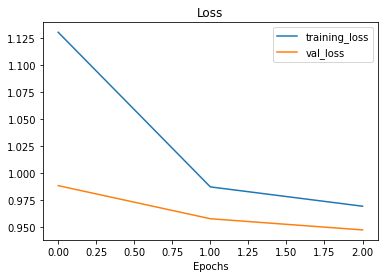

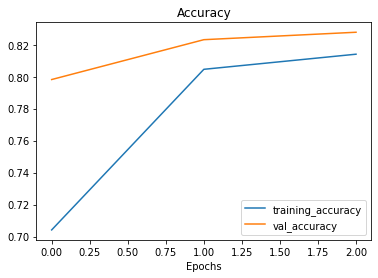

In [65]:
plot_loss_curves(tribed_track)

Model Results Analysis

In [66]:
hybrid_model_probs = tri_model.predict(val_everything_data)
hybrid_preds = tf.argmax(hybrid_model_probs, axis = 1 )
model_results = calculate_results(val_labels_encoded,hybrid_preds)
model_results

{'accuracy': 82.8346352442738,
 'f1': 0.8270044487013223,
 'precision': 0.8274111050327015,
 'recall': 0.828346352442738}